# Machine Learning Model Deployment Project

## Introduction

Welcome to the Machine Learning Model Deployment Project! This notebook serves as the foundation for the summative assignment where I design, build, and deploy a classification model. The goal is to create an end-to-end ML pipeline—starting from data preprocessing and model training to deployment on a cloud platform with scalability and user interaction features.

In this project, I will:
- Develop a classification model using a tabular dataset of teenage pregnancies in Rwanda.
- Evaluate its performance using key metrics such as accuracy, precision, recall, and F1-score.
- Construct a modular pipeline with Python functions for preprocessing, training, and prediction.
- Deploy the pipeline as a dockerized web application on a cloud platform enabling features like real-time predictions, data uploads, and model retraining.
- Test the deployed model’s scalability by simulating a flood of requests and analyzing latency and response times.

NB: The dataset used is synthetic due to the lack of non-generic Rwandan data online. However, it was synthesised using Rwandan data online. Some of these features are age ranges of kids and the level of education they would be expected to have and economic classes which are referred to as Ubudehe Categories.

This notebook will walk through the offline development and evaluation of the model, laying the groundwork for the full deployment process. The final solution will be a user-friendly, scalable application that demonstrates practical ML engineering skills.


## TASK 1: BUILDING AND SAVING A CLASSIFICATION MODEL

In [1]:
import pandas as pd


file_path = 'teenage_pregnancies_in_Rwanda_data.csv'

#Load the data
data = pd.read_csv(file_path)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# dividing the dataset into Train, Validation, and test sets

X = data.drop('Risk_Category', axis=1)
y = data['Risk_Category']

# For the categorical features
X = pd.get_dummies(X, columns=['Education_Level', 'Ubudehe_Category', 'Contraceptive_Use'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [3]:
import joblib
import os

# Create directories if they don't exist
os.makedirs("../data/train", exist_ok=True)
os.makedirs("../data/test", exist_ok=True)

# Save training and validation sets
joblib.dump(X_train, "../data/train/X_train.pkl")
joblib.dump(X_val, "../data/train/X_val.pkl")
joblib.dump(y_train, "../data/train/y_train.pkl")
joblib.dump(y_val, "../data/train/y_val.pkl")

# Save test set
joblib.dump(X_test, "../data/test/X_test.pkl")
joblib.dump(y_test, "../data/test/y_test.pkl")


['../data/test/y_test.pkl']

In [5]:
# one-hot encoding for the risk categories

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pickle

# Load the saved data
with open('../data/train/X_train.pkl', 'rb') as f:
    X_train = joblib.load(f)

with open('../data/train/y_train.pkl', 'rb') as f:
    y_train = joblib.load(f)

with open('../data/train/X_val.pkl', 'rb') as f:
    X_val = joblib.load(f)

with open('../data/train/y_val.pkl', 'rb') as f:
    y_val = joblib.load(f)

with open('../data/test/X_test.pkl', 'rb') as f:
    X_test = joblib.load(f)

with open('../data/test/y_test.pkl', 'rb') as f:
    y_test = joblib.load(f)

# Encoding the risk categories
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# one-hot encoding for the risk categories
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val_encoded, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [6]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2

def define_model(optimization: str, regularization_type: str = None, regularization_strength: float = 0.0, early_stopping: bool = False, learning_rate: float = False):
    # Initialize the model
    model = Sequential()

    def get_regularizer(reg_type, reg_strength):
        if reg_type == 'l1':
            return l1(reg_strength) if reg_strength > 0 else None
        elif reg_type == 'l2':
            return l2(reg_strength) if reg_strength > 0 else None
        elif reg_type == 'l1_l2':
            return l1_l2(l1=reg_strength, l2=reg_strength) if reg_strength > 0 else None
        else:
            return None

    # First dense layer with optional L2 regularization
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=get_regularizer(regularization_type, regularization_strength)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second dense layer
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=get_regularizer(regularization_type, regularization_strength)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third dense layer
    model.add(Dense(8, activation='relu',
                    kernel_regularizer=get_regularizer(regularization_type, regularization_strength)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer with 3 neurons for multi-class classification
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimization,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks for early stopping if required
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

    return model, callbacks

# Printing out the loss final model accuracy and ploting the loss curve

Function to plot the loss curve

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def loss_curve_plot(history, y_test=None, y_pred=None):
    epochs = range(1, len(history.history['loss']) + 1)

    train_accuracy = history.history.get('accuracy', history.history.get('acc'))
    val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

Model combinations with different optimization techniques

c:\Users\user\nganiriza\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3650 - loss: 1.5404 - val_accuracy: 0.5350 - val_loss: 1.0440
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3991 - loss: 1.3129 - val_accuracy: 0.7000 - val_loss: 0.9494
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4710 - loss: 1.1425 - val_accuracy: 0.7800 - val_loss: 0.8616
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5019 - loss: 1.0593 - val_accuracy: 0.8200 - val_loss: 0.7818
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5469 - loss: 1.0157 - val_accuracy: 0.8450 - val_loss: 0.7089
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6126 - loss: 0.9171 - val_accuracy: 0.8750 - val_loss: 0.6457
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7041 - loss: 0.7551 - val_accuracy: 0.9000 - val_loss: 0.5979
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6844 - loss: 0.7701 - val_accuracy: 0.9050 -

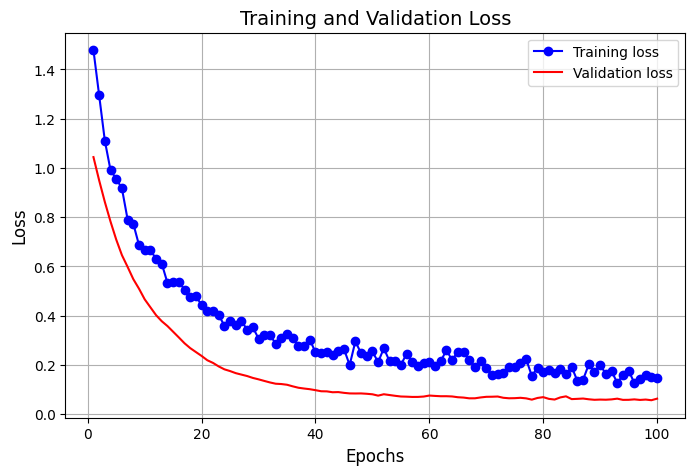

Final Training Accuracy: 0.9517
Final Validation Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       0.99      0.98      0.98        82
   High Risk       0.97      0.99      0.98       116

    accuracy                           0.97       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.97      0.97      0.97       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


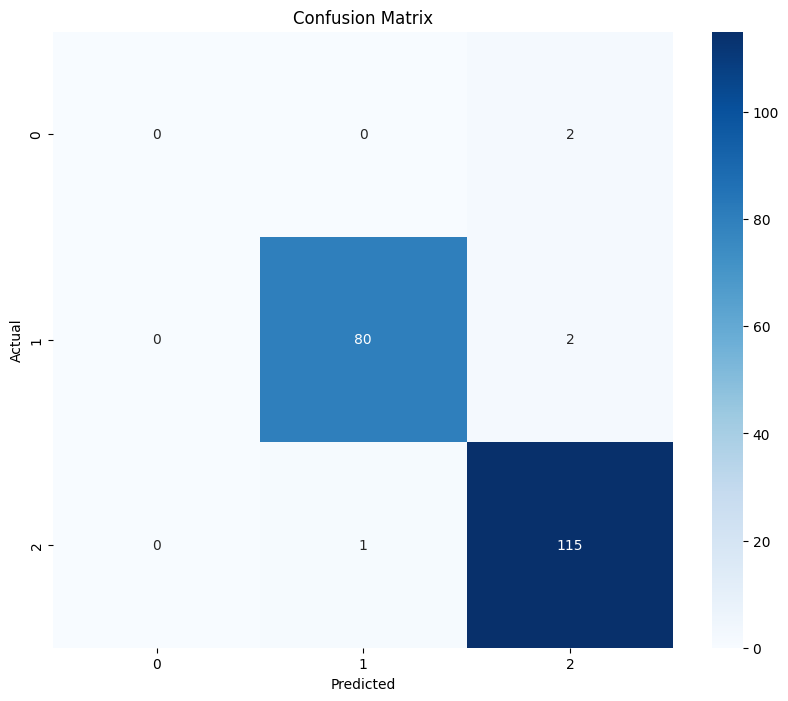

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Default model (No optimization techniques)

default_model, _ = define_model(
    optimization='adam',
    regularization_type=None,
    regularization_strength=0.0,
    early_stopping=False,
    learning_rate=0.01
)

history = default_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
)

y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(default_model.predict(X_test), axis=1)
loss_curve_plot(history, y_test_labels, y_pred)

#confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/100


c:\Users\user\nganiriza\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4043 - loss: 12.4886 - val_accuracy: 0.5250 - val_loss: 11.5841
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4646 - loss: 11.5944 - val_accuracy: 0.6550 - val_loss: 10.8757
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5201 - loss: 10.8067 - val_accuracy: 0.7900 - val_loss: 10.1623
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6303 - loss: 10.0036 - val_accuracy: 0.8700 - val_loss: 9.4555
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5946 - loss: 9.3975 - val_accuracy: 0.8950 - val_loss: 8.7669
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7271 - loss: 8.5824 - val_accuracy: 0.9050 - val_loss: 8.0998
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6930 - loss: 7.9794 - val_accuracy: 0.9150 - val_loss: 7.4487
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7409 - loss: 7.3324 - val_accuracy: 0.9150 - val_

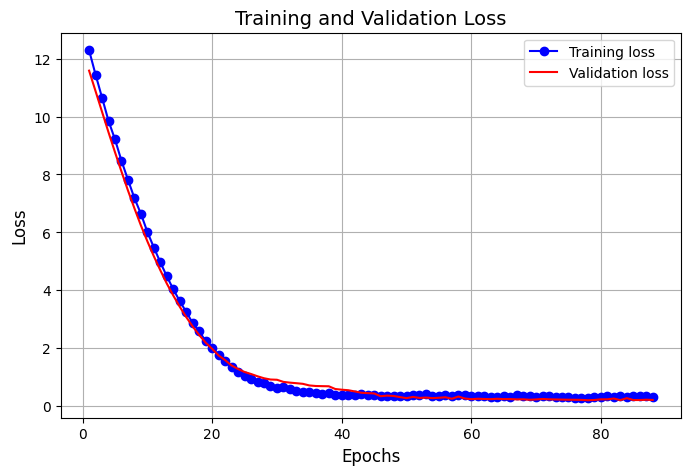

Final Training Accuracy: 0.9533
Final Validation Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       0.98      1.00      0.99        82
   High Risk       0.98      0.98      0.98       116

    accuracy                           0.98       200
   macro avg       0.65      0.66      0.66       200
weighted avg       0.97      0.98      0.98       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


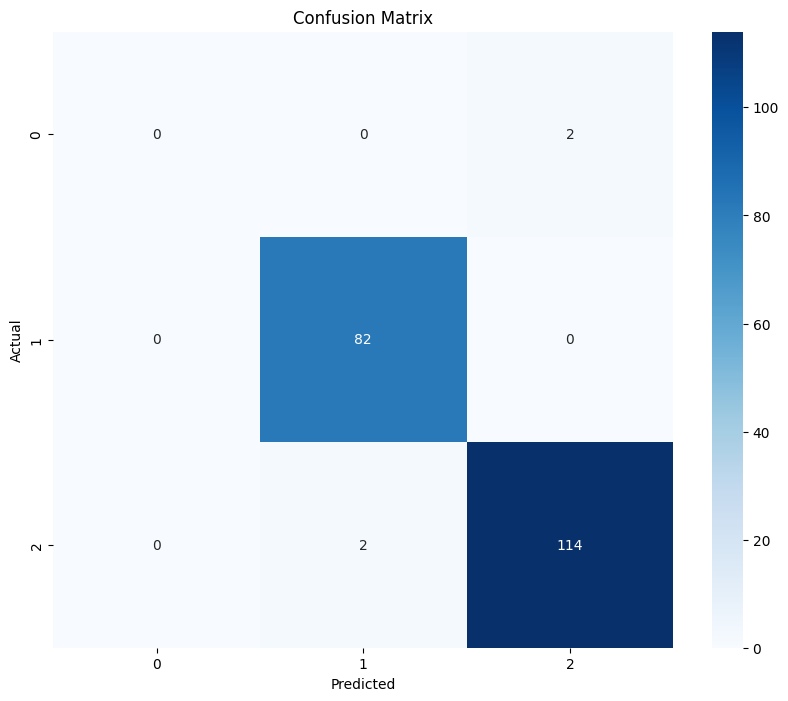

In [9]:
# Neural network model 1

import numpy as np

nn_model_1, callbacks = define_model(
    optimization='adam',
    regularization_type='l1',
    regularization_strength=0.05,
    early_stopping=True,
    learning_rate=0.001
)

history = nn_model_1.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(nn_model_1.predict(X_test), axis=1)
loss_curve_plot(history, y_test_labels, y_pred)

#confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The validation accuracy was higher than the training accuracy and this comes as a result of using the L1 Regularizer as it helps with generalising better on unseen data. However, the confusion matrix indicate that Low Risk samples were missclassified as High Risk classes. This confirms that the model doesn't work well with predicting Low Risk.

Epoch 1/100


c:\Users\user\nganiriza\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3499 - loss: 6.2316 - val_accuracy: 0.4650 - val_loss: 5.4801
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3978 - loss: 5.6311 - val_accuracy: 0.6250 - val_loss: 5.0360
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4557 - loss: 5.1332 - val_accuracy: 0.7250 - val_loss: 4.6150
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5345 - loss: 4.6470 - val_accuracy: 0.8300 - val_loss: 4.2147
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5505 - loss: 4.2749 - val_accuracy: 0.9000 - val_loss: 3.8471
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6442 - loss: 3.8377 - val_accuracy: 0.9150 - val_loss: 3.5031
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6395 - loss: 3.5612 - val_accuracy: 0.9150 - val_loss: 3.1963
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6641 - loss: 3.2789 - val_accuracy: 0.9150 - val_loss: 2

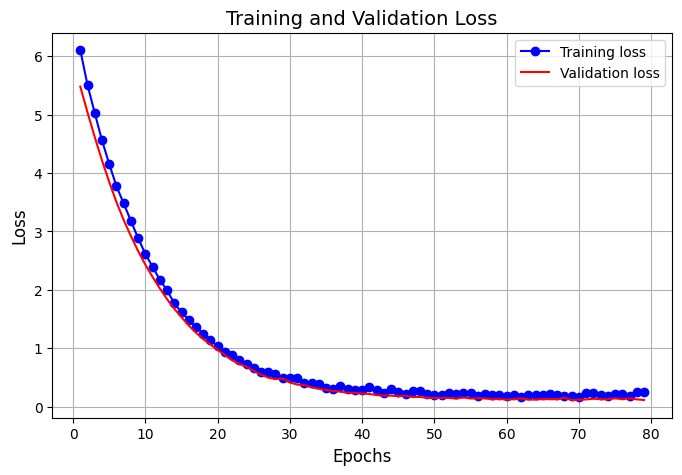

Final Training Accuracy: 0.9267
Final Validation Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       1.00      1.00      1.00        82
   High Risk       0.98      1.00      0.99       116

    accuracy                           0.99       200
   macro avg       0.66      0.67      0.66       200
weighted avg       0.98      0.99      0.99       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


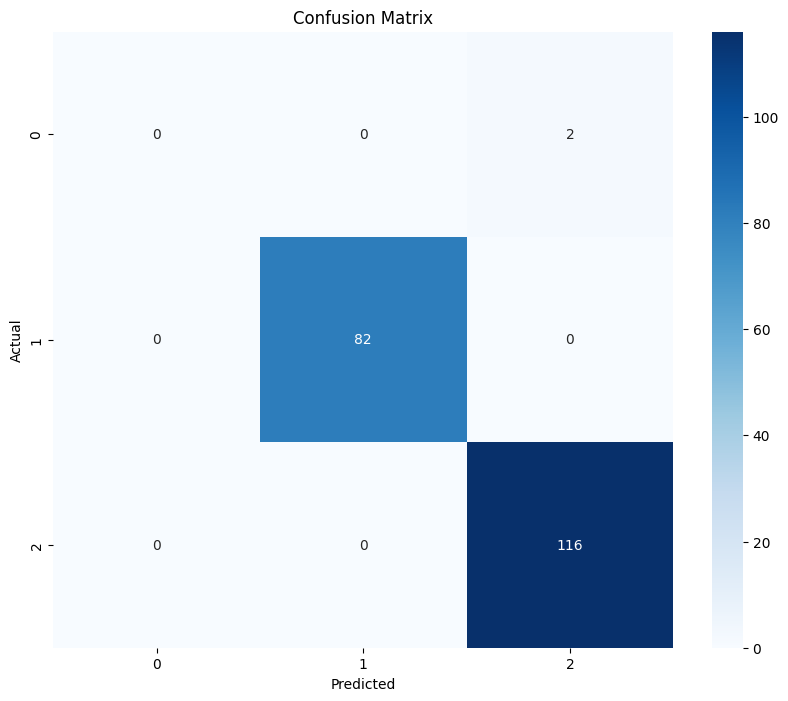

In [10]:
# Neural network model 2

nn_model_2, callbacks = define_model(
    optimization='adam',
    regularization_type='l2',
    regularization_strength=0.09,
    early_stopping=True,
    learning_rate=0.001
)

history = nn_model_2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(nn_model_2.predict(X_test), axis=1)
loss_curve_plot(history, y_test_labels, y_pred)

#confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The use of L2 regularization assures the prevention of overfitting since L2 regularization penalizes large weights more smoothly which encourages smaller weights overall. Also, results show a decrease in the loss compared to the previous model which indicates better perfomance of the model. However same as the previous model, the confusion matrix fails to predict low risk categories.

c:\Users\user\nganiriza\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3232 - loss: 108.8031 - val_accuracy: 0.6600 - val_loss: 97.7853
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3246 - loss: 95.3944 - val_accuracy: 0.6100 - val_loss: 87.1240
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4244 - loss: 84.8170 - val_accuracy: 0.6100 - val_loss: 77.3608
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4382 - loss: 75.1592 - val_accuracy: 0.6100 - val_loss: 68.2442
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4781 - loss: 66.1971 - val_accuracy: 0.6050 - val_loss: 59.7360
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5081 - loss: 57.7991 - val_accuracy: 0.6000 - val_loss: 51.7848
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5842 - loss: 49.9302 - val_accuracy: 0.6000 - val_loss: 44.4000
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5469 - loss: 42.7631 - val_

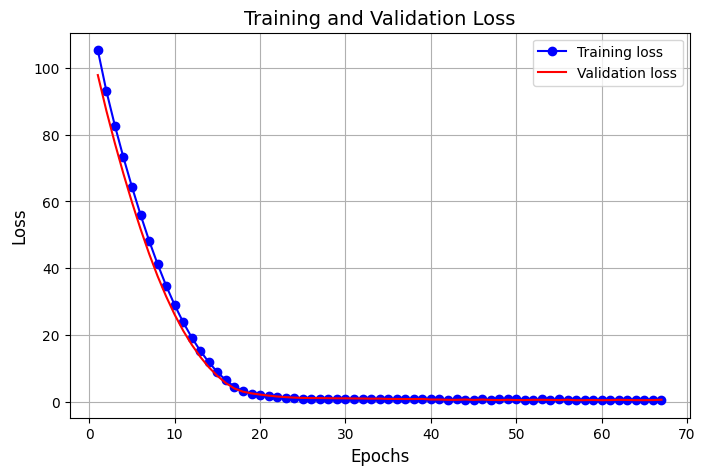

Final Training Accuracy: 0.9100
Final Validation Accuracy: 0.8900

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       0.99      0.98      0.98        82
   High Risk       0.97      0.99      0.98       116

    accuracy                           0.97       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.97      0.97      0.97       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


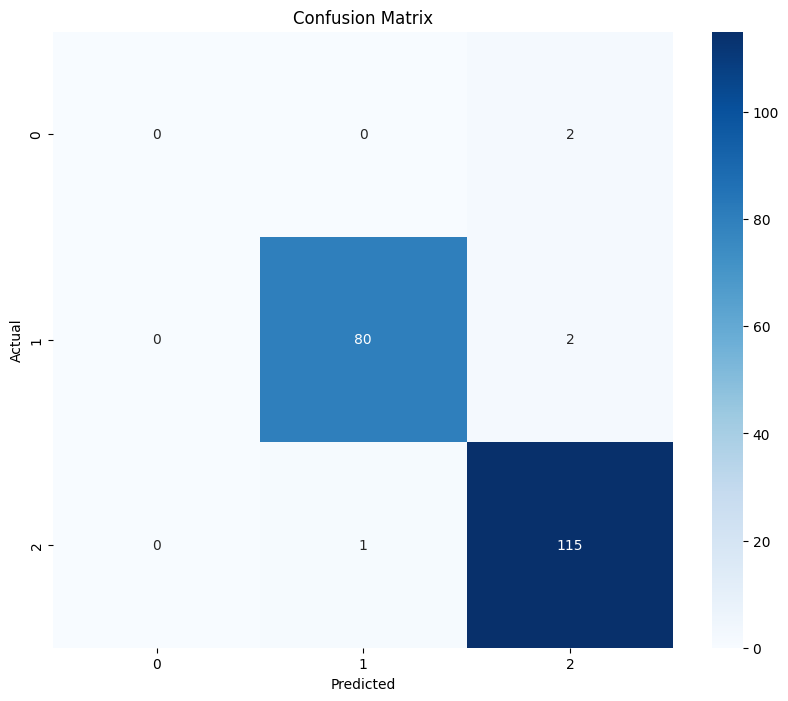

In [11]:
# Neural network model 3

nn_model_3, callbacks = define_model(
    optimization='RMSProp',
    regularization_type='l1',
    regularization_strength=0.5,
    early_stopping=True,
    learning_rate=0.001
)

history = nn_model_3.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(nn_model_3.predict(X_test), axis=1)
loss_curve_plot(history, y_test_labels, y_pred)

#confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Using RMSProp didn't help as much as shown from the results. Training and validation accuracies dropped significantly, suggesting underfitting, and the train and validation losses also increased which confirmed the underfitting. Also, the confusion matrix once again shows failure in predicting the low risk categories. We can conclude that RMSProp is the worst perfoming model so far.

Epoch 1/100


c:\Users\user\nganiriza\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3032 - loss: 28.0187 - val_accuracy: 0.4300 - val_loss: 24.1811
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3595 - loss: 23.5989 - val_accuracy: 0.6350 - val_loss: 20.3268
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5086 - loss: 19.7800 - val_accuracy: 0.6550 - val_loss: 16.9486
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5747 - loss: 16.3807 - val_accuracy: 0.6450 - val_loss: 14.0049
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6406 - loss: 13.3639 - val_accuracy: 0.6200 - val_loss: 11.4343
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6399 - loss: 10.8659 - val_accuracy: 0.6150 - val_loss: 9.1409
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7413 - loss: 8.5269 - val_accuracy: 0.6100 - val_loss: 7.1598
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7666 - loss: 6.5787 - val_accuracy: 0.6000 - 

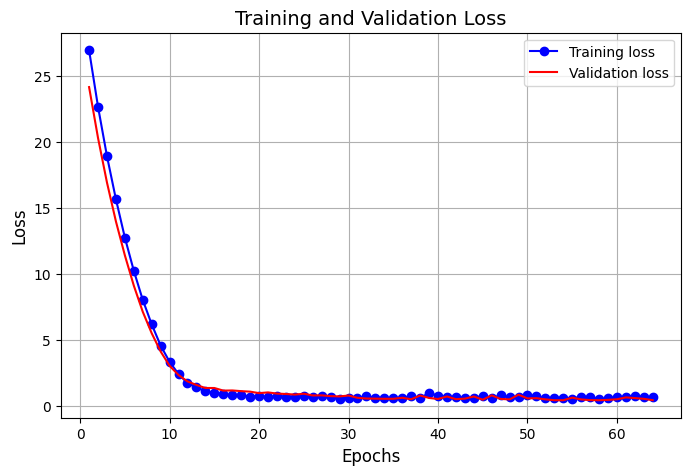

Final Training Accuracy: 0.8717
Final Validation Accuracy: 0.9650

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       0.88      1.00      0.94        82
   High Risk       0.98      0.91      0.94       116

    accuracy                           0.94       200
   macro avg       0.62      0.64      0.63       200
weighted avg       0.93      0.94      0.93       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


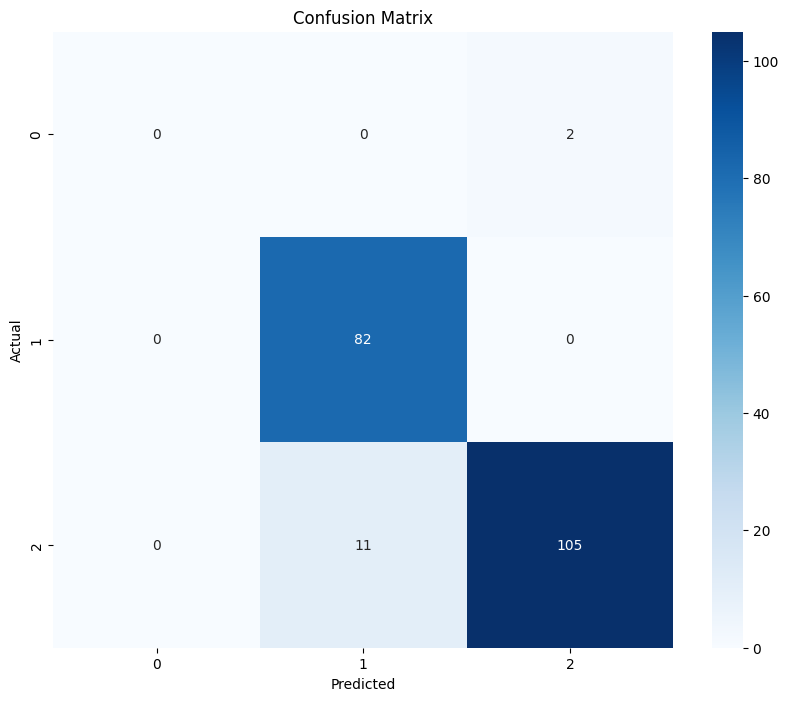

In [12]:
# Neural network model 4

nn_model_4, callbacks = define_model(
    optimization='sgd',
    regularization_type='l1_l2',
    regularization_strength=0.1,
    early_stopping=True,
    learning_rate=0.001
)

history = nn_model_4.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(nn_model_4.predict(X_test), axis=1)
loss_curve_plot(history, y_test_labels, y_pred)

#confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

I used SGD which updates weights using a fixed learning rate without momentum or adaptive learning rate adjustments, which can lead to avoid overfitting in some cases. With a combination of L1 and L2 without intensifying alot also contributed less underfitting. From the results, the train and validation accuracies indicate possible underfit of the training data but better generalization on the validation data. The issue of missclassifying low risk categories still persist which doesn't make this the best as well.

Epoch 1/100


c:\Users\user\nganiriza\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2753 - loss: 4.6907 - val_accuracy: 0.4700 - val_loss: 3.8645
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3100 - loss: 4.3154 - val_accuracy: 0.4550 - val_loss: 3.7601
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3341 - loss: 4.0827 - val_accuracy: 0.5900 - val_loss: 3.6422
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4209 - loss: 3.8111 - val_accuracy: 0.7050 - val_loss: 3.5202
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4638 - loss: 3.6578 - val_accuracy: 0.7350 - val_loss: 3.3926
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5145 - loss: 3.5200 - val_accuracy: 0.7800 - val_loss: 3.2585
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5838 - loss: 3.3205 - val_accuracy: 0.8300 - val_loss: 3.1234
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6045 - loss: 3.1995 - val_accuracy: 0.9200 - val_loss: 2

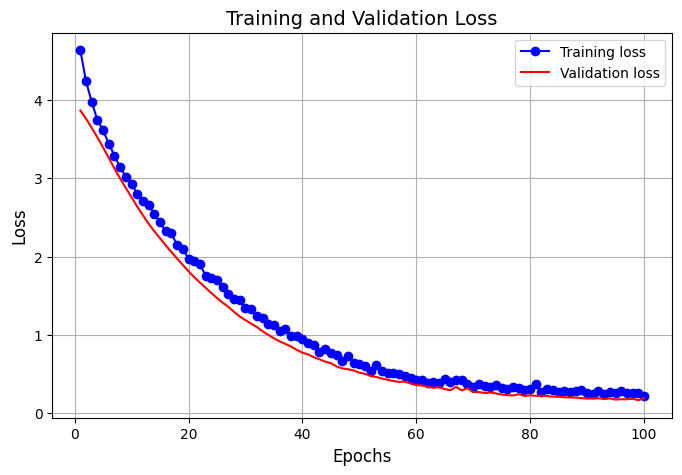

Final Training Accuracy: 0.9683
Final Validation Accuracy: 0.9750

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       0.98      1.00      0.99        82
   High Risk       0.98      0.98      0.98       116

    accuracy                           0.98       200
   macro avg       0.65      0.66      0.66       200
weighted avg       0.97      0.98      0.98       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


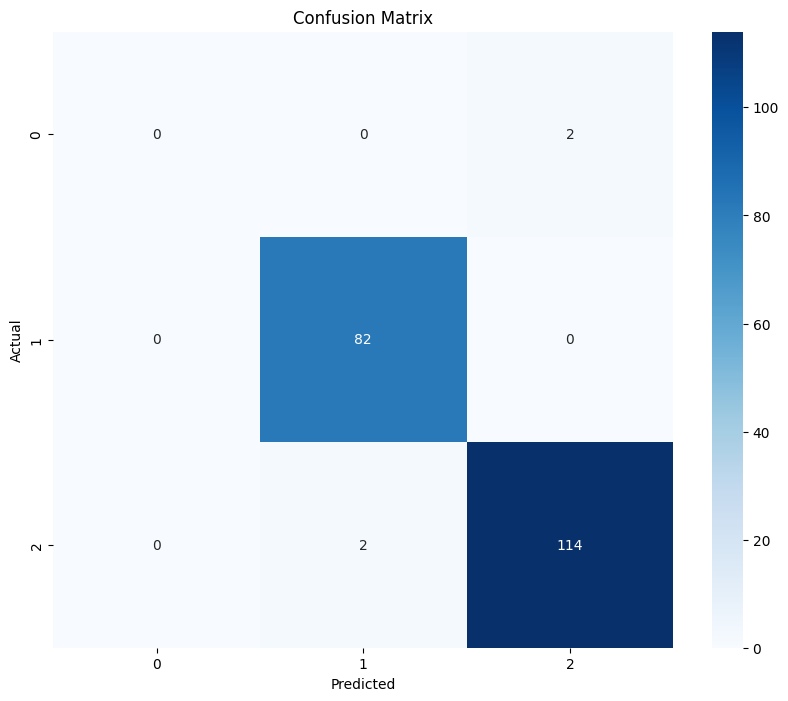

In [13]:
# Neural network model 5

nn_model_5, callbacks = define_model(
    optimization='adam',
    regularization_type='l1_l2',
    regularization_strength=0.01,
    early_stopping=True,
    learning_rate=0.001
)

history = nn_model_5.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(nn_model_5.predict(X_test), axis=1)
loss_curve_plot(history, y_test_labels, y_pred)

#confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model
nn_model_5.save("../models/nn_model_5.h5")

I changed back to adam optimization and this resulted into high training accuracy and validation accuracy indicating nice generalization and less overfitting due to the combination of adam and reduced strength of L1_L2 regularizers.

In [ ]:
# Saving the confusion matrix

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("../models/confusion_matrix.png")
plt.close()


In [14]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np

def svm_model(X_train, y_train, X_test, y_test):
    # One-hot encoding: Convert y_train and y_test from one-hot to class labels
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    # Initialize and train the SVM model
    model = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

    return model

# Call the function with your data
svm_model(X_train, y_train, X_test, y_test)

Model Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.00      0.00      0.00         2
 Medium Risk       0.93      0.96      0.95        82
   High Risk       0.96      0.95      0.95       116

    accuracy                           0.94       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.94      0.94      0.94       200



c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\nganiriza\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVC(random_state=42)

The fifth model is the best one so far so it was the one saved that i saved with its evaluation metrics and confusion table.

In [15]:
# Tesing the saved model

import keras

def make_predictions(model_path, X_test):
    # Load the model
    loaded_model = tf.keras.models.load_model(model_path)

    # Make predictions
    predictions = loaded_model.predict(X_test)

    # Convert probabilities to binary labels (0 or 1)
    predicted_classes = np.argmax(predictions, axis=1)

    return predictions, predicted_classes

In [16]:
# Make predictions
model_path = '../models/nn_model_5.h5'
predictions, predicted_classes = make_predictions(model_path, X_test)

print("Raw Probabilities:\n", predictions)
print("Predicted Classes:\n", predicted_classes)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Raw Probabilities:
 [[3.99241596e-03 9.86767948e-01 9.23969410e-03]
 [3.76925687e-03 9.85833704e-01 1.03970487e-02]
 [2.92668189e-03 8.88108450e-04 9.96185124e-01]
 [1.29878493e-02 8.97255421e-01 8.97566900e-02]
 [2.38049473e-03 1.00883422e-04 9.97518659e-01]
 [8.66070297e-03 1.13792773e-02 9.79960084e-01]
 [2.48725363e-03 9.93231058e-01 4.28173598e-03]
 [4.01529623e-03 1.02478114e-03 9.94959950e-01]
 [1.30962795e-02 8.98847342e-01 8.80563855e-02]
 [5.65444701e-04 9.98995483e-01 4.39105032e-04]
 [3.58756422e-03 1.01216661e-03 9.95400250e-01]
 [2.19757529e-03 1.43435202e-04 9.97658968e-01]
 [4.19506384e-03 2.60125683e-03 9.93203640e-01]
 [4.21030354e-03 2.86470517e-03 9.92925048e-01]
 [2.07756646e-03 4.05122992e-04 9.97517347e-01]
 [1.87346595e-03 4.33344801e-04 9.97693121e-01]
 [1.49854878e-03 1.80830451e-04 9.98320639e-01]
 [1.30413733e-02 9.12386835e-01 7.45717660e-02]
 [1.78665039e-04 9.99764740e-01 5.65469600e-05]
 [4.05086111e-03 2.02411367e-0

## Python functions for the pipeline process

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Data preprocessing
def preprocess_data(X, fit_scaler=True, scaler=None):
    """
    Preprocess input data by scaling it.
    
    Args:
        X (np.ndarray): Input data to preprocess.
        fit_scaler (bool): Whether to fit a new scaler or use an existing one.
        scaler (StandardScaler, optional): Pre-fitted scaler for transformation.
    
    Returns:
        tuple: Processed data and scaler object.
    
    Raises:
        ValueError: If input data is invalid or scaler is missing when required.
    """
    try:
        # Check if X is a valid numpy array
        if not isinstance(X, np.ndarray):
            raise ValueError("Input X must be a numpy array")
        
        if fit_scaler:
            # Create and fit a new scaler
            scaler = StandardScaler()
            X_processed = scaler.fit_transform(X)
        else:
            # Use existing scaler
            if scaler is None:
                raise ValueError("Scaler must be provided when fit_scaler=False")
            X_processed = scaler.transform(X)
        
        return X_processed, scaler
    
    except ValueError as ve:
        print(f"ValueError in preprocess_data: {ve}")
        raise
    except Exception as e:
        print(f"Unexpected error in preprocess_data: {e}")
        raise

# Model training/loading
def get_model(model_path=None):
    """
    Load an existing model or define a new one.
    
    Args:
        model_path (str, optional): Path to a saved model file.
    
    Returns:
        tuple: Model and callbacks (if new), or just the loaded model.
    
    Raises:
        FileNotFoundError: If model_path is invalid or file doesn't exist.
        Exception: For other loading or model definition errors.
    """
    try:
        if model_path and os.path.exists(model_path):
            return tf.keras.models.load_model(model_path)
        else:
            # Assuming define_model is defined elsewhere
            model, callbacks = define_model(
                optimization='adam',
                regularization_type='l1_l2',
                regularization_strength=0.01,
                early_stopping=True,
                learning_rate=0.001
            )
            return model, callbacks
    
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        raise
    except Exception as e:
        print(f"Error in get_model: {e}")
        raise

# Making predictions
def make_predictions(model_path, X_test):
    """
    Load a model and make predictions on test data.
    
    Args:
        model_path (str): Path to the saved model file.
        X_test (np.ndarray): Test data for predictions.
    
    Returns:
        tuple: Raw probabilities and predicted classes.
    
    Raises:
        FileNotFoundError: If model file is missing.
        ValueError: If X_test is invalid.
        Exception: For prediction-related errors.
    """
    try:
        # Check inputs
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at {model_path}")
        if not isinstance(X_test, np.ndarray):
            raise ValueError("X_test must be a numpy array")
        
        # Load model and predict
        loaded_model = tf.keras.models.load_model(model_path)
        predictions = loaded_model.predict(X_test)
        predicted_classes = np.argmax(predictions, axis=1)
        
        return predictions, predicted_classes
    
    except FileNotFoundError as fe:
        print(f"FileNotFoundError in make_predictions: {fe}")
        raise
    except ValueError as ve:
        print(f"ValueError in make_predictions: {ve}")
        raise
    except Exception as e:
        print(f"Error in make_predictions: {e}")
        raise